# Proteção de Dados Sensíveis

Lidar com documentos sensíveis sempre foi um desafio, principalmente neste momento em que a segurança dos dados tem se tornado uma pauta cada vez mais presente nas discussões sobre tecnologia. Em meio a esse contexto, gostaríamos de propor uma **demonstração de censura de dados sensíveis em diferentes tipos de arquivo, realizada de forma automática, por meio de um modelo de IA.**

||
| --- |
| Neste notebook, iremos realizar a censura de dados sensíveis em textos e em imagens. Esta tarefa é conhecida como "Person Identifiable Information Detection". |

#### 1) Importação de bibliotecas necessárias

In [1]:
from PIL import Image
from presidio_image_redactor import ImageRedactorEngine
from presidio_image_redactor.image_analyzer_engine import ImageAnalyzerEngine, TesseractOCR, ImageRecognizerResult
from presidio_analyzer import AnalyzerEngine, RecognizerResult, EntityRecognizer, RecognizerRegistry
from presidio_analyzer.nlp_engine import NlpEngine, NlpEngineProvider
from presidio_analyzer.context_aware_enhancers import (
    LemmaContextAwareEnhancer,
)
from presidio_anonymizer import AnonymizerEngine
from typing import List
import boto3
import os
import pandas as pd
import json

#### 2) Configuração do modelo para a língua portuguesa

ℹ️ - Nessa tarefa utilizaremos o [Presidio Analyzer da Microsoft](https://microsoft.github.io/presidio/analyzer/), um analisador de dados não estruturados, em conjunto com o modelo "pt_core_news_lg" da Spacy para a identificação de dados sensíveis em textos escritos em língua portuguesa.

In [2]:
LANGUAGES_CONFIG_FILE = "pt.yaml"

# Cria o modelo com base na linguagem definida anteriormente
provider = NlpEngineProvider(conf_file=LANGUAGES_CONFIG_FILE)
nlp_engine_with_portuguese = provider.create_engine()

In [3]:
class PortugueseImageAnalyzerEngine(ImageAnalyzerEngine):
    """ImageAnalyzerEngine class.

    :param analyzer_engine: The Presidio AnalyzerEngine instance
        to be used to detect PII in text
    :param ocr: the OCR object to be used to detect text in images.
    """

    def __init__(self, analyzer_engine: AnalyzerEngine=None, ocr=None):
        if not analyzer_engine:
            analyzer_engine = AnalyzerEngine(
                supported_languages=["pt"], 
                nlp_engine=nlp_engine_with_portuguese
            )
        self.analyzer_engine = analyzer_engine

        if not ocr:
            ocr = TesseractOCR()
        self.ocr = ocr

    def analyze(self, image: object, ocr_kwargs=None, **kwargs) -> List[ImageRecognizerResult]:
        """Analyse method to analyse the given image.

        :param image: PIL Image/numpy array or file path(str) to be processed
        :param kwargs: Additional values for the analyze method in AnalyzerEngine

        :return: list of the extract entities with image bounding boxes
        """
        ocr_result = self.ocr.perform_ocr(image)
        text = self.ocr.get_text_from_ocr_dict(ocr_result)

        analyzer_result = self.analyzer_engine.analyze(
            text=text, language="pt", **kwargs
        )
        bboxes = self.map_analyzer_results_to_bounding_boxes(
            analyzer_result, ocr_result, text
        )
        return bboxes

In [4]:
class PortugueseAnalyzerEngine(AnalyzerEngine):
    """ImageAnalyzerEngine class.

    :param analyzer_engine: The Presidio AnalyzerEngine instance
        to be used to detect PII in text
    :param ocr: the OCR object to be used to detect text in images.
    """

    def __init__(self, analyzer_engine: AnalyzerEngine=None):
        if not analyzer_engine:
            analyzer_engine = AnalyzerEngine(
                supported_languages=["pt"], 
                nlp_engine=nlp_engine_with_portuguese
            )
        self.analyzer_engine = analyzer_engine


    def analyze(self, text:str, **kwargs) -> List[RecognizerResult]:
        """Analyse method to analyse the given image.

        :param image: PIL Image/numpy array or file path(str) to be processed
        :param kwargs: Additional values for the analyze method in AnalyzerEngine

        :return: list of the extract entities with image bounding boxes
        """
        analyzer_result = self.analyzer_engine.analyze(
            text=text, language="pt", **kwargs
        )
        return analyzer_result

#### 3) Censura de dados sensíveis em imagens
3.1) Leitura da imagem do processo

In [5]:
# Leitura da imagem
image = Image.open("data/image.png")

3.2) Aplicação do modelo

In [6]:
# Inicializa o modelo
engine = ImageRedactorEngine(image_analyzer_engine=PortugueseImageAnalyzerEngine())

# Recria a imagem aplicando o modelo e censurando os dados sensíveis com a cor rosa
redacted_image = engine.redact(image, (255, 192, 203))

3.3) Visualização do resultado

1️⃣ - Imagem original:


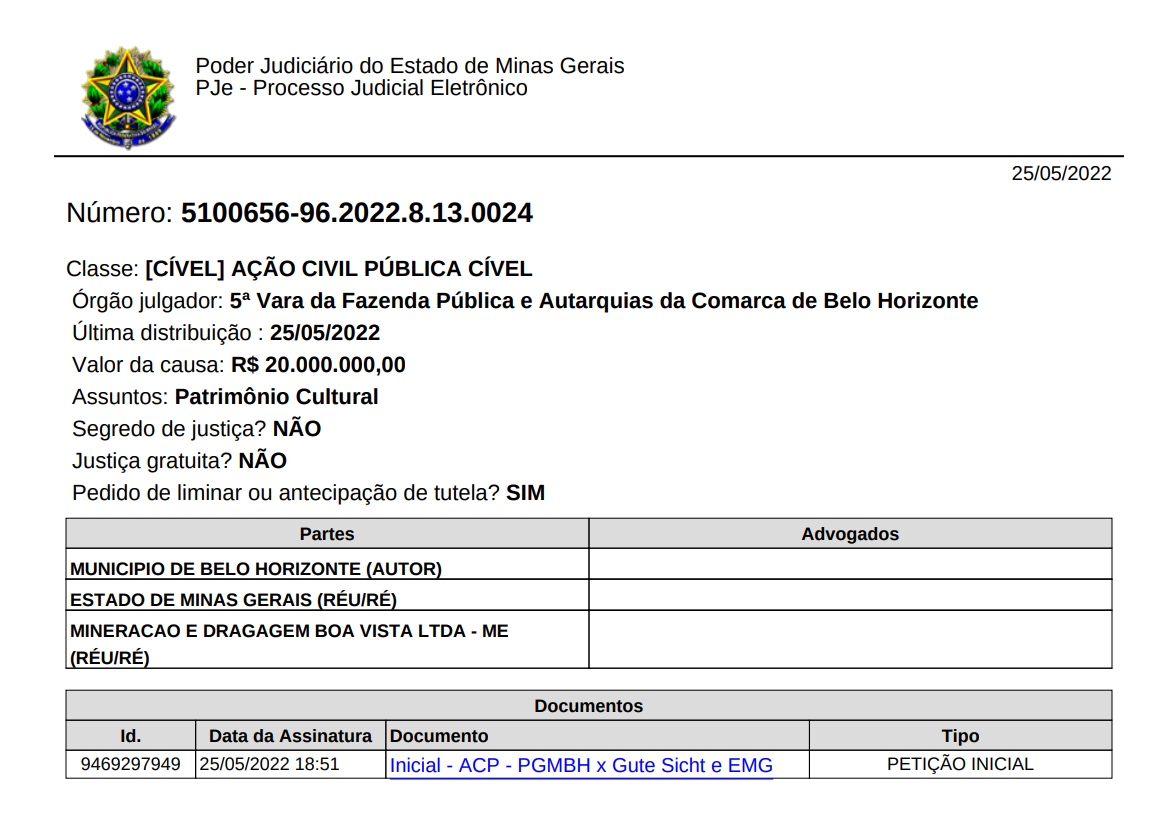

In [9]:
print("1️⃣ - Imagem original:")
image

2️⃣ Imagem censurada:


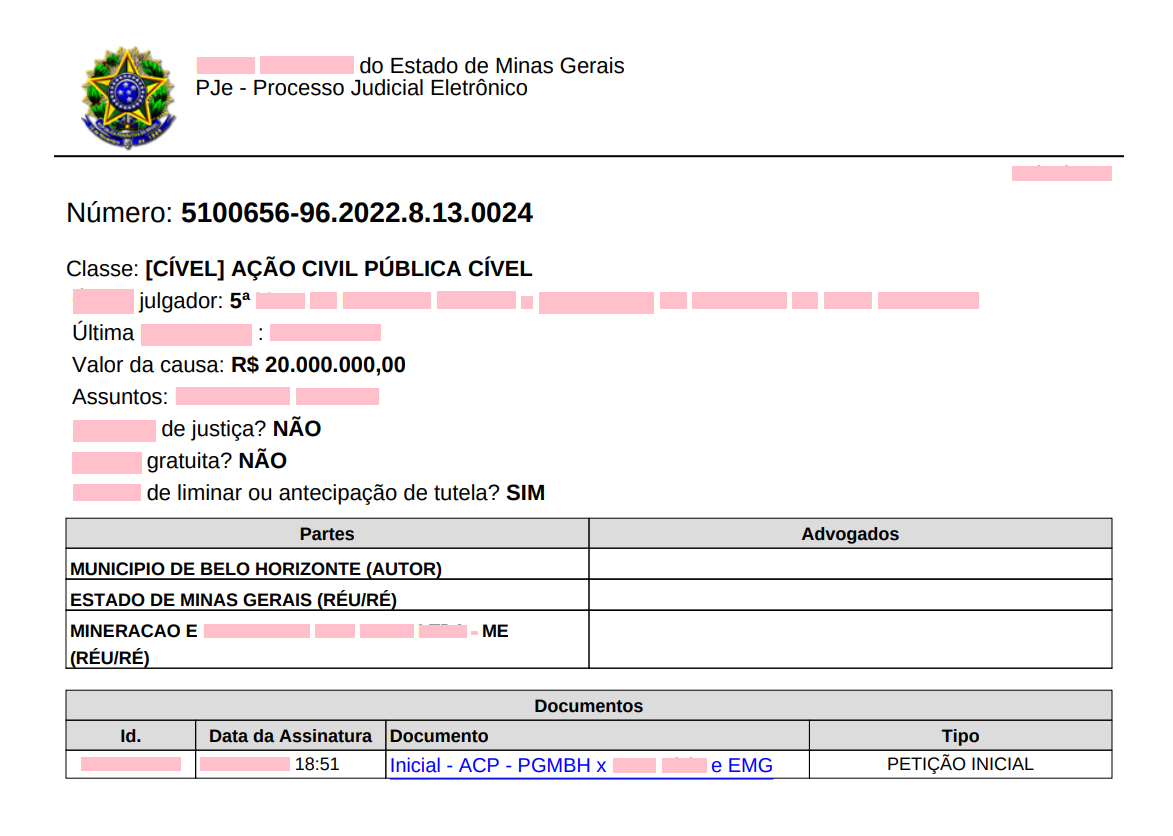

In [10]:
print("2️⃣ Imagem censurada:")
redacted_image

> **Observações:**
> Note que alguns campos com dados sensíveis foram censurados, como a identificação do documento, o assunto, a causa do Processo e a data, mas nem todos os campos não foram detectados como sensíveis. Nesta demonstração não iremos aprofundar mais no assunto, mas é possível obter um resultado melhor utilizando um modelo mais adaptado aos dados.

3.4) Salvar a imagem censurada

In [8]:
# Salva a imagem censurada
redacted_image.save("data/censored_image.png")

#### 4) Censura de dados sensíveis em textos
4.1) Leitura do texto de processo a ser censurado

In [9]:
# Login na AWS S3
client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('DEV_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('DEV_SECRET_KEY'),
        region_name='us-east-1'
    )

# Download do documento de processos da AWS S3
bucket = 'bucket-demo-teste-ds'
file_path = 'ocr/processes/extracted/extracted_corpus.json'
local_file_path = 'data/process_corpus.json'

client.download_file(bucket, file_path, local_file_path)

In [10]:
# Abrindo arquivo json com o corpo de texto dos processos
f = open('data/process_corpus.json')
data = json.load(f)

# Carregando arquivo .json como uma tabela
corpus_df = pd.read_json(data)

# Buscando texto do processo id "5100656-96.2022.8.13.0024" que é o que iremos analisar
text = corpus_df[corpus_df["id"] == "5100656-96.2022.8.13.0024"]["corpus"].iloc[0][7493:8500].lower().replace("\n","")

4.2) Aplicação do modelo

In [11]:
# Detectando as palavras que podem conter informações sensíveis
analyzer_engine = PortugueseAnalyzerEngine()

results = analyzer_engine.analyze(text=text,
                        entities=["PHONE_NUMBER","PERSON","IP_ADDRESS","EMAIL_ADDRESS"])

# Censurando as palavras
anonymizer = AnonymizerEngine()
anonymized_text = anonymizer.anonymize(text=text, analyzer_results=results)

4.3) Visualização do resultado

In [12]:
print("1️⃣ - Texto Original\n")
print(text)

print("\n2️⃣ - Texto Censurado\n")
print(anonymized_text.text)

print("\n\nLocalização das palavras censuradas:\n")
print(anonymized_text.items)

1️⃣ - Texto Original

assinado eletronicamente por: caio costa perona - 25/05/2022 18:51:13 num. 9469297949 - pag. 4  municipio de belo horizonte .procuradoria-geral do municipio — subprocuradoria-geral do contenciosopublicada diario oficial do municipio - belo horizonte ano x - n°: 2.030 -01/07/2004.a importancia cultural e hist6rica da serra do curral é tamanha que, em 1995,em eleicéo promovida pela prefeitura municipal de belo horizonte, a serra docurral disputou o titulo de simbolo da cidade, juntamente com outros significativosexemplares, como a igreja sado francisco de assis e praca da liberdade, sendo eleitacom um total de 268.767 votos.e evidente, portanto, que a serra do curral constitui um patriménio culturale paisagistico cuja histéria se confunde com a propria histéria da capital mineira,constituindo-se como simbolo maximo da identidade belo-horizontina.1.2. do empreendimento objeto da acaoa ré mineracao gute sicht ltda € responsavel peloempreendimento mineracao boa vista,

Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
